In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0610/weights_KD_segformer_0610_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 0.0343

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 505ms/step - loss: 0.0241
Average validation loss: 0.6249480843544006
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 517ms/step - loss: 0.0241 - val_loss: 0.6249
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 500ms/step - loss: 0.0158 - val_loss: 0.6249
Average validation loss: 0.6196805238723755
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 511ms/step - loss: 0.0158 - val_loss: 0.6223
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 508ms/step - loss: 0.0114 - val_loss: 0.6223
Average validation loss: 0.5441229939460754
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 519ms/step - loss: 0.0114 - val_loss: 0.5963
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segform

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 845ms/step - loss: 1.9486e-07
Average validation loss: 0.11255693063139915
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 854ms/step - loss: 1.9486e-07 - val_loss: 0.1126
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 795ms/step - loss: 1.9318e-07 - val_loss: 0.1126
Average validation loss: 0.08210219070315361
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 807ms/step - loss: 1.9318e-07 - val_loss: 0.0973
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_10.pth'.
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 774ms/step - loss: 1.8287e-07 - val_loss: 0.0973
Average validation loss: 0.13654658943414688
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 788ms/step - loss: 1.8287e-07 - val_loss: 0.1104
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 26s 811ms/step - loss: 1.8672e-07 - val_loss: 0.

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 828ms/step - loss: 8.4765e-08
Average validation loss: 0.0322132334113121
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 839ms/step - loss: 8.4765e-08 - val_loss: 0.0322
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 800ms/step - loss: 8.0638e-08 - val_loss: 0.0322
Average validation loss: 0.03193701306978861
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 809ms/step - loss: 8.0638e-08 - val_loss: 0.0321
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 803ms/step - loss: 7.8526e-08 - val_loss: 0.0321
Average validation loss: 0.026861955411732197
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 812ms/step - loss: 7.8526e-08 - val_loss: 0.0303
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weigh

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 840ms/step - loss: 4.6736e-08
Average validation loss: 0.020808686851523817
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 849ms/step - loss: 4.6736e-08 - val_loss: 0.0208
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 882ms/step - loss: 4.3376e-08 - val_loss: 0.0208
Average validation loss: 0.01943147834390402
16/16 ━━━━━━━━━━━━━━━━━━━━ 28s 891ms/step - loss: 4.3376e-08 - val_loss: 0.0201
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 824ms/step - loss: 4.2257e-08 - val_loss: 0.0201
Average validation loss: 0.017994327703490853
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 835ms/step - loss: 4.2257e-08 - val_loss: 0.0194
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\wei

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 840ms/step - loss: 2.5316e-08
Average validation loss: 0.011462700227275491
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 852ms/step - loss: 2.5316e-08 - val_loss: 0.0115
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 794ms/step - loss: 2.2672e-08 - val_loss: 0.0115
Average validation loss: 0.01928331647068262
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 804ms/step - loss: 2.2672e-08 - val_loss: 0.0154
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 779ms/step - loss: 2.0977e-08 - val_loss: 0.0154
Average validation loss: 0.011534525081515312
20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 790ms/step - loss: 2.0977e-08 - val_loss: 0.0141
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 784ms/step - loss: 2.0440e-08 - val_loss: 0.0141
Average validation loss: 0.011165557312779129
20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 795ms/step - loss: 2.0440e-08 - val_loss: 0.0134
Saved m

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 788ms/step - loss: 4.8440e-08
Average validation loss: 0.015493423173514506
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 797ms/step - loss: 4.8440e-08 - val_loss: 0.0155
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 969ms/step - loss: 4.3902e-08 - val_loss: 0.0155
Average validation loss: 0.010786284692585468
24/24 ━━━━━━━━━━━━━━━━━━━━ 43s 979ms/step - loss: 4.3902e-08 - val_loss: 0.0131
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 65s 908ms/step - loss: 3.6839e-08 - val_loss: 0.0131
Average validation loss: 0.011679986142553389
24/24 ━━━━━━━━━━━━━━━━━━━━ 65s 917ms/step - loss: 3.6839e-08 - val_loss: 0.0127
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 84s 782ms/step - loss: 3.3167

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 780ms/step - loss: 5.7566e-08
Average validation loss: 0.05074864614289254
40/40 ━━━━━━━━━━━━━━━━━━━━ 32s 790ms/step - loss: 5.7566e-08 - val_loss: 0.0507
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 62s 769ms/step - loss: 4.3101e-08 - val_loss: 0.0507
Average validation loss: 0.036786187591496856
40/40 ━━━━━━━━━━━━━━━━━━━━ 63s 778ms/step - loss: 4.3101e-08 - val_loss: 0.0438
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 780ms/step - loss: 3.5102e-08 - val_loss: 0.0438
Average validation loss: 0.0233033609110862
40/40 ━━━━━━━━━━━━━━━━━━━━ 94s 789ms/step - loss: 3.5102e-08 - val_loss: 0.0369
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weigh

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 778ms/step - loss: 1.5072e-07
Average validation loss: 0.016257110439861815
48/48 ━━━━━━━━━━━━━━━━━━━━ 38s 789ms/step - loss: 1.5072e-07 - val_loss: 0.0163
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 75s 779ms/step - loss: 1.6559e-07 - val_loss: 0.0163
Average validation loss: 0.013683550564261774
48/48 ━━━━━━━━━━━━━━━━━━━━ 76s 791ms/step - loss: 1.6559e-07 - val_loss: 0.0150
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_60.pth'.
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 113s 780ms/step - loss: 1.7498e-07 - val_loss: 0.0150
Average validation loss: 0.012407507107127458
48/48 ━━━━━━━━━━━━━━━━━━━━ 114s 791ms/step - loss: 1.7498e-07 - val_loss: 0.0141
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 778ms/step - loss: 1.6987e-08
Average validation loss: 0.007856755550684673
56/56 ━━━━━━━━━━━━━━━━━━━━ 44s 790ms/step - loss: 1.6987e-08 - val_loss: 0.0079
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 88s 788ms/step - loss: 2.2569e-08 - val_loss: 0.0079
Average validation loss: 0.014348963608167
56/56 ━━━━━━━━━━━━━━━━━━━━ 89s 799ms/step - loss: 2.2569e-08 - val_loss: 0.0111
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 135s 817ms/step - loss: 2.0915e-08 - val_loss: 0.0111
Average validation loss: 0.007540065512460258
56/56 ━━━━━━━━━━━━━━━━━━━━ 136s 828ms/step - loss: 2.0915e-08 - val_loss: 0.0099
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 181s 798ms/step - loss: 1.9001

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 62s 970ms/step - loss: 1.2168e-08
Average validation loss: 0.008289054603665136
64/64 ━━━━━━━━━━━━━━━━━━━━ 63s 981ms/step - loss: 1.2168e-08 - val_loss: 0.0083
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 116s 837ms/step - loss: 1.0694e-08 - val_loss: 0.0083
Average validation loss: 0.009160002780845389
64/64 ━━━━━━━━━━━━━━━━━━━━ 117s 848ms/step - loss: 1.0694e-08 - val_loss: 0.0087
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 167s 778ms/step - loss: 9.9676e-09 - val_loss: 0.0087
Average validation loss: 0.006727212312398478
64/64 ━━━━━━━━━━━━━━━━━━━━ 168s 789ms/step - loss: 9.9676e-09 - val_loss: 0.0081
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_80.pth'.
Epoch 4/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 217s 776ms/step - loss: 9

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 777ms/step - loss: 8.7412e-09
Average validation loss: 0.0071003836346790195
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 788ms/step - loss: 8.7412e-09 - val_loss: 0.0071
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 780ms/step - loss: 8.0522e-09 - val_loss: 0.0071
Average validation loss: 0.01087025264536755
72/72 ━━━━━━━━━━━━━━━━━━━━ 114s 791ms/step - loss: 8.0522e-09 - val_loss: 0.0090
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 776ms/step - loss: 7.5431e-09 - val_loss: 0.0090
Average validation loss: 0.014514541007681854
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 787ms/step - loss: 7.5431e-09 - val_loss: 0.0108
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 777ms/step - loss: 7.1215e-09 - val_loss: 0.0108
Average validation loss: 0.007859911446252631
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 787ms/step - loss: 7.1215e-09 - val_loss: 0.0101


c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 776ms/step - loss: 2.9076e-09
Average validation loss: 0.004423086473252624
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 786ms/step - loss: 2.9076e-09 - val_loss: 0.0044
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 126s 787ms/step - loss: 3.8089e-09 - val_loss: 0.0044
Average validation loss: 0.01248209091136232
80/80 ━━━━━━━━━━━━━━━━━━━━ 127s 798ms/step - loss: 3.8089e-09 - val_loss: 0.0085
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 190s 786ms/step - loss: 3.9609e-09 - val_loss: 0.0085
Average validation loss: 0.04430165570229292
80/80 ━━━━━━━━━━━━━━━━━━━━ 191s 797ms/step - loss: 3.9609e-09 - val_loss: 0.0204
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 253s 787ms/step - loss: 3.6760e-09 - val_loss: 0.0204
Average validation loss: 0.011136473016813397
80/80 ━━━━━━━━━━━━━━━━━━━━ 254s 799ms/step - loss: 3.6760e-09 - val_loss: 0.0181
E

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 75s 783ms/step - loss: 3.2320e-07
Average validation loss: 0.027845417188170057
96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 794ms/step - loss: 3.2320e-07 - val_loss: 0.0278
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 778ms/step - loss: 2.3770e-07 - val_loss: 0.0278
Average validation loss: 0.0132400781828134
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 790ms/step - loss: 2.3770e-07 - val_loss: 0.0205
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 774ms/step - loss: 2.0987e-07 - val_loss: 0.0205
Average validation loss: 0.011350216838764027
96/96 ━━━━━━━━━━━━━━━━━━━━ 228s 785ms/step - loss: 2.0987e-07 - val_loss: 0.0175
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1D

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 787ms/step - loss: 2.5366e-07
Average validation loss: 0.027821563634400567
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 797ms/step - loss: 2.5366e-07 - val_loss: 0.0278
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 798ms/step - loss: 2.4125e-07 - val_loss: 0.0278
Average validation loss: 0.007862722345938286
120/120 ━━━━━━━━━━━━━━━━━━━━ 193s 809ms/step - loss: 2.4125e-07 - val_loss: 0.0178
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 290s 808ms/step - loss: 1.8344e-07 - val_loss: 0.0178
Average validation loss: 0.008665744308382272
120/120 ━━━━━━━━━━━━━━━━━━━━ 291s 819ms/step - loss: 1.8344e-07 - val_loss: 0.0148
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 384s 773m

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 778ms/step - loss: 2.6996e-08
Average validation loss: 0.010971488379355934
144/144 ━━━━━━━━━━━━━━━━━━━━ 114s 789ms/step - loss: 2.6996e-08 - val_loss: 0.0110
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 225s 775ms/step - loss: 3.1608e-08 - val_loss: 0.0110
Average validation loss: 0.015800622925679717
144/144 ━━━━━━━━━━━━━━━━━━━━ 227s 786ms/step - loss: 3.1608e-08 - val_loss: 0.0134
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 775ms/step - loss: 2.7147e-08 - val_loss: 0.0134
Average validation loss: 0.009630853549525555
144/144 ━━━━━━━━━━━━━━━━━━━━ 340s 786ms/step - loss: 2.7147e-08 - val_loss: 0.0121
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_180.pth'.
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 452s 77

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 775ms/step - loss: 4.4948e-08
Average validation loss: 0.009144343817024492
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 786ms/step - loss: 4.4948e-08 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 249s 768ms/step - loss: 4.3149e-08 - val_loss: 0.0091
Average validation loss: 0.008700280035554897
160/160 ━━━━━━━━━━━━━━━━━━━━ 250s 779ms/step - loss: 4.3149e-08 - val_loss: 0.0089
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 376s 785ms/step - loss: 4.8813e-08 - val_loss: 0.0089
Average validation loss: 0.012139899251633324
160/160 ━━━━━━━━━━━━━━━━━━━━ 378s 796ms/step - loss: 4.8813e-08 - val_loss: 0.0100
Epoch 4/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 504s 78

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 156s 782ms/step - loss: 2.2023e-08
Average validation loss: 0.013596676532179117
200/200 ━━━━━━━━━━━━━━━━━━━━ 159s 793ms/step - loss: 2.2023e-08 - val_loss: 0.0136
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 314s 775ms/step - loss: 1.9338e-08 - val_loss: 0.0136
Average validation loss: 0.009398011709636193
200/200 ━━━━━━━━━━━━━━━━━━━━ 316s 786ms/step - loss: 1.9338e-08 - val_loss: 0.0115
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_250.pth'.
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 471s 778ms/step - loss: 1.7929e-08 - val_loss: 0.0115
Average validation loss: 0.009024802068597636
200/200 ━━━━━━━━━━━━━━━━━━━━ 474s 789ms/step - loss: 1.7929e-08 - val_loss: 0.0107
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 187s 779ms/step - loss: 1.6180e-08
Average validation loss: 0.0075217968139137765
240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 790ms/step - loss: 1.6180e-08 - val_loss: 0.0075
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 375s 771ms/step - loss: 1.3489e-08 - val_loss: 0.0075
Average validation loss: 0.006504841579589993
240/240 ━━━━━━━━━━━━━━━━━━━━ 378s 783ms/step - loss: 1.3489e-08 - val_loss: 0.0070
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0610/weights_KD_segformer_0610_0\segformer_data_size_300.pth'.
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 564s 775ms/step - loss: 1.3254e-08 - val_loss: 0.0070
Average validation loss: 0.006440373295724082
240/240 ━━━━━━━━━━━━━━━━━━━━ 566s 786ms/step - loss: 1.3254e-08 - val_loss: 0.0068
Saved model weights to 'c:\天_11157065\git\Ripp

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.18023562036454677, 0.04884657533839345, 0.020143190779878452, 0.01612259157351218, 0.012336062863003466, 0.007461316333307575, 0.06181545009789989, 0.019759297927763934, 0.27073368556664457, 0.016334619621920864, 0.008248317056762367, 0.02007564273366006, 0.028179788058429644, 0.01666624734978768, 0.31452436308714027, 0.010409114983202015, 0.00891855455579771, 0.010864917126760248]
std_val_losses =  [0.22227620716201885, 0.033838419057522946, 0.010195439323581934, 0.007223551541904851, 0.0056534602154400026, 0.0030115311074804638, 0.1517439295608873, 0.022473398834498202, 1.709343179847211, 0.027646622739119317, 0.006516272149562819, 0.02711704820089517, 0.0799740151288587, 0.011858558003126204, 1.6441094091140351, 0.0023448942191508673, 0.00271652193837447, 0.009338718147628601]


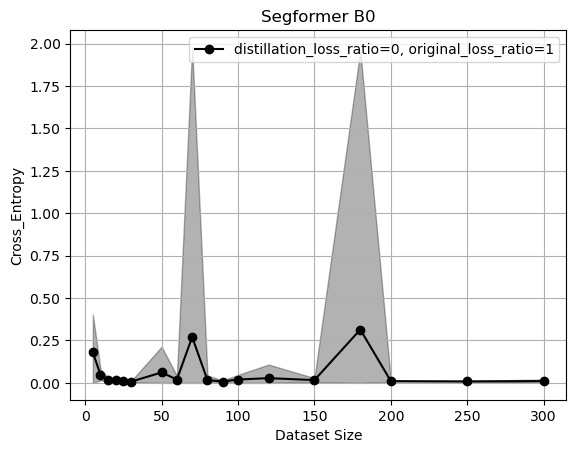

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0610')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0610_{int(teacher_ratio*100)}.png"))

plt.show()